# Generative Adversarial Network on MNIST database using Keras.

We start our project with importing all python tools needed. We also import MNIST database with 60000 images of handwritten digits.

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape, Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

/home/agnieszka/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

We will reshape our data, so the algorithm is easily adaptable to multichannel images, eg. RGB. We also scale it, so the input values are contained in [0,1] interval.

In [3]:
X_train = X_train.reshape(-1,28,28,1)
X_train = X_train.astype('float32')/255
data_num = X_train.shape[0]

Next step is creating discriminator. We define a function which takes as input list of numbers of filters in *Conv2D* layers, parameter *alpha* for _LeakyReLU_ layers, type of optimizer in compilation of the model, and dropout value. We use *strides* in *Conv2D* instead of *MaxPooling*. We choose filter shape to be (5,5) in every *Conv2D* layer.

In [4]:
def create_discriminator(filters, alpha, optimizer, dropout): 
    discriminator = Sequential()
    discriminator.add(Conv2D(filters[0], 5, strides=2, input_shape=X_train.shape[1:]))
    discriminator.add(LeakyReLU(alpha=alpha))
    discriminator.add(Dropout(dropout))
    discriminator.add(Conv2D(filters[1], 5, strides=2, padding='same'))
    discriminator.add(LeakyReLU(alpha=alpha))
    discriminator.add(Dropout(dropout))
    discriminator.add(Conv2D(filters[2], 5, strides=2, padding='same'))
    discriminator.add(LeakyReLU(alpha=alpha))
    discriminator.add(Dropout(dropout))
    discriminator.add(Conv2D(filters[3], 5, strides=1, padding='same'))
    discriminator.add(LeakyReLU(alpha=alpha))
    discriminator.add(Dropout(dropout))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return discriminator

In [5]:
def create_generator(dim, depth, input_dim, momentum, dropout):
    generator = Sequential()
    
    generator.add(Dense(dim*dim*depth, input_dim=100))
    generator.add(BatchNormalization(momentum=momentum))
    generator.add(Activation('relu'))
    generator.add(Reshape((dim, dim, depth)))
    generator.add(Dropout(dropout))


    generator.add(UpSampling2D())
    generator.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    generator.add(BatchNormalization(momentum=momentum))
    generator.add(Activation('relu'))
    

    generator.add(UpSampling2D())
    generator.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    generator.add(BatchNormalization(momentum=momentum))
    generator.add(Activation('relu'))    

    generator.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    generator.add(BatchNormalization(momentum=momentum))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(1, 5, padding='same'))
    generator.add(Activation('sigmoid'))
    return generator

In [6]:
def create_adversarial(generator, discriminator, optimizer):
    adversarial = Sequential()
    adversarial.add(generator)
    adversarial.add(discriminator)
    adversarial.layers[1].trainable = False
    adversarial.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return adversarial

In [7]:
def train_GAN(epochs, batch_size, generator, adversarial):
    batches = int(data_num/batch_size)
    d_losses = []
    d_accuracies = []
    a_losses = []
    a_accuracies =[]
    for i in range(epochs):
        print("Epoch:",i)
        list_idx = list(range(data_num))
        np.random.shuffle(list_idx)
        list_idx = list_idx[:batch_size*batches]
        batches_idx=np.split(np.array(list_idx), batches)
        for j in range(batches):
            images_train = X_train[batches_idx[j]]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss, d_acc = discriminator.train_on_batch(x, y)
            d_losses.append(d_loss)
            d_accuracies.append(d_acc)
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss, a_acc = adversarial.train_on_batch(noise, y)
            a_losses.append(a_loss)
            d_accuracies.append(d_acc)
        noise = np.random.uniform(-1.0, 1.0, size=[6, 100])
        plt.figure(figsize=(12,4))
        for i in range(1,7):
            plt.subplot(1, 6, i)
            plt.imshow(generator.predict(noise)[i-1][:,:,0], cmap = 'gray_r')
            plt.axis('off')
        plt.show()
    return d_losses, d_accuracies, a_losses , a_accuracies

In [8]:
optimizer_d = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
optimizer_a = Adam(lr=0.0004, clipvalue=1.0, decay=1e-10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 4307969   
Total params: 6,702,210
Trainable params: 2,368,705
Non-trainable params: 4,333,505
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 12, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_____________________________________________________

/home/agnieszka/.local/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


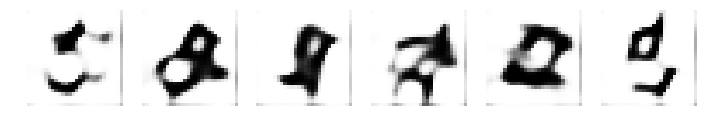

Epoch: 1


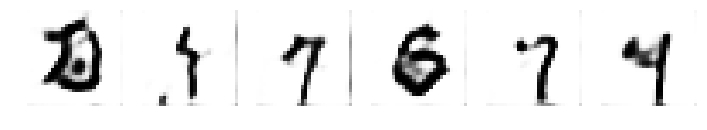

Epoch: 2


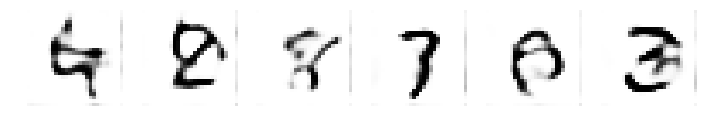

Epoch: 3


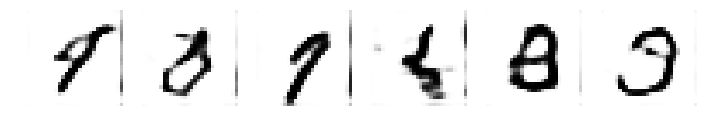

Epoch: 4


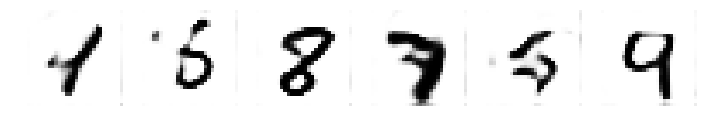

In [9]:
discriminator = create_discriminator(filters =[64,128,256,512], alpha=0.2, optimizer=optimizer_d, dropout=0.4)
generator = create_generator(dim=7, depth=256, input_dim=100, momentum=0.9, dropout=0.4)
adversarial = create_adversarial(generator, discriminator, optimizer=optimizer_a)
print(adversarial.summary())
print(discriminator.summary())

d_losses, d_accuracies, a_losses , a_accuracies= train_GAN(epochs=5, batch_size=256, generator=generator, adversarial=adversarial)

In [10]:
print(discriminator.summary())
print(adversarial.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 12, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 256)         819456    
__________

/home/agnieszka/.local/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


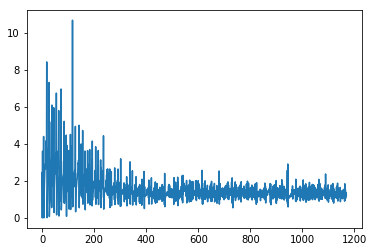

In [11]:
plt.plot(a_losses)

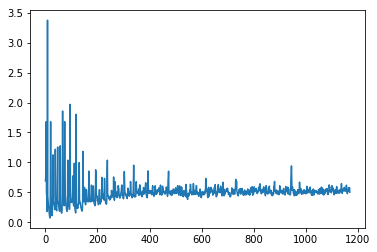

In [12]:
plt.plot(d_losses)

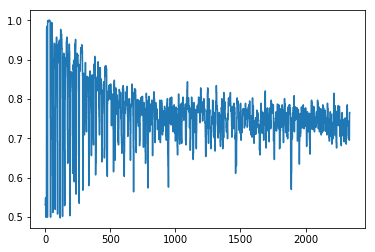

In [13]:
plt.plot(d_accuracies)